In [1]:
from lib_learning.nn_monitoring.loss import LossMonitor
from lib_learning.nn.ffnn import FFNN
from lib_learning.nn.cnn import CNN

import gzip
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import tensorflow as tf
import plotly.offline as plotly
import plotly.graph_objs as go
from PIL import Image

In [2]:
%matplotlib inline
plotly.init_notebook_mode(connected=True)

# Problem Statement

Here we compare convolutional neural networks against the feed-forwards variety on MNIST with the aim of improving test accuracy and reduce the number of trainable parameters. We then inspect the filters / convoluted images to see if the "learned features" are human interprable in any way.

Furthermore we show that it is a easier task to learn pattersn from the learned convolutional feature representation of images than it is to classify the raw images itself.

# Data

In [3]:
with gzip.open('../data/MNIST_data/test_inputs.gz', 'rb') as f:
    test_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('../data/MNIST_data/train_inputs.gz', 'rb') as f:
    train_in = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28) / 255.0
with gzip.open('../data/MNIST_data/test_targets.gz', 'rb') as f:
    test_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open('../data/MNIST_data/train_targets.gz', 'rb') as f:
    train_labels_raw = np.frombuffer(f.read(), np.uint8, offset=8)
    
test_labels = np.zeros((test_labels_raw.shape[0], 10))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
train_labels = np.zeros((train_labels_raw.shape[0], 10))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1

test_in = test_in.astype('float32')
train_in = train_in.astype('float32')
test_lables = test_labels.astype('float32')
train_lables = train_labels.astype('float32')

In [4]:
# Run this if you want to normalize to zero mean
test_in = test_in - train_in.mean()
train_in = train_in - train_in.mean()

# Feed Forwards Baseline

Here we see that four hidden layers with 128 nodes each achieves 97.88% testing accuracy. Our goal is therefore to beat this number using at most this many parameters.

Tally of number of parameters:
- layer 1: 784 * 128 + 128 = 100480
- layer 2: 128 * 128 + 128 = 16512
- layer 3: 128 * 128 + 128 = 16512
- layer 4: 128 * 128 + 128 = 16512
- layer 5: 128 * 10 + 10 = 1290
- total: 100480 + 16512 + 16512 + 16512 + 1290 = 151306

In [5]:
d = tf.data.Dataset.from_tensor_slices((train_in, train_labels))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [6]:
lc = [
    784,
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 128, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 10, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    }
]

In [7]:
def cross_entropy_with_softmax(model_output, true_output):
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(labels=true_output, logits=model_output))

In [8]:
monitors = [LossMonitor(200)]

In [9]:
%%time
ffnn = FFNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
ffnn.init_session()
for epoch in range(1):
    ffnn.session.run(iterator.initializer)
    ffnn.train_online()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 6min, sys: 29.2 s, total: 6min 29s
Wall time: 1min 19s


In [10]:
plotly.iplot(ffnn.monitors[0].plot())

In [11]:
train_pred = ffnn.predict(train_in)
np.sum(train_pred.argmax(axis=1) == train_labels.argmax(axis=1)) / train_in.shape[0]

0.99555

In [12]:
train_pred = ffnn.predict(test_in)
np.sum(train_pred.argmax(axis=1) == test_labels.argmax(axis=1)) / test_in.shape[0]

0.9741

# Convolutional Classifier

We achieve significantly better performance (between 98.35% and 98.55%) with only 8648 trainable parameters.

Tally of number of parameters:
- layer 1: 5 \* 5 * 8 = 200
- layer 2: 5 \* 5 \* 8 * 8 = 1600
- layer 3: 5 \* 5 \* 8 * 8 = 1600
- layer 4: 72 * 64 = 4608
- layer 5: 64 * 10 = 640
- total: 200 + 1600 + 1600 + 4608 + 640 = 8648

In [13]:
d = tf.data.Dataset.from_tensor_slices((train_in.reshape((60000, 28, 28, 1)), train_labels))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [14]:
lc = [
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 1, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [24, 24, 8]
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001,
        'stride_size': [1, 3, 3, 1],
        'activation': tf.tanh,
        'output_size': [7, 7, 8]
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [3, 3, 8]
    },
    {
        'layer_type': 'reshape',
        'new_shape': [72]
    },
    {
        'layer_type': 'connected',
        'input_dim': 72,
        'output_size': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_size': 10,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.001,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.001
    }
]

In [15]:
monitors = [LossMonitor(200)]

In [16]:
%%time
cnn = CNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
cnn.init_session()
for epoch in range(1):
    cnn.session.run(iterator.initializer)
    cnn.train_online()

CPU times: user 48min, sys: 57.6 s, total: 48min 58s
Wall time: 5min 43s


In [17]:
plotly.iplot(cnn.monitors[0].plot())

In [18]:
train_pred = cnn.predict(train_in.reshape((60000, 28, 28, 1)))
np.sum(train_pred.argmax(axis=1) == train_labels.argmax(axis=1)) / train_in.shape[0]

0.99125

In [19]:
train_pred = cnn.predict(test_in.reshape((10000, 28, 28, 1)))
np.sum(train_pred.argmax(axis=1) == test_labels.argmax(axis=1)) / test_in.shape[0]

0.9865

# Exploring CNN Filters

In [20]:
filters_1 = cnn.session.run(cnn.lc[0]['filter'])

def feed_forwards(self, input_vector, n):    
    for i in range(n):
        lc = self.lc[i]

        if lc['layer_type'] == 'conv':
            input_vector = tf.nn.conv2d(
                input=input_vector,
                filter=lc['filter'],
                strides=lc['stride_size'],
                padding='VALID'
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'conv_transpose':
            input_vector = tf.nn.conv2d_transpose(
                value=input_vector,
                filter=lc['filter'],
                output_shape=lc['output_size'],
                strides=lc['stride_size']
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'connected':
            a = lc['activation']
            w = lc['weights']
            b = lc['biases']
            input_vector = a(tf.matmul(input_vector, w) + b)

        elif lc['layer_type'] == 'pool':
            if lc['pool_type'] == 'average':
                input_vector = tf.nn.avg_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )
            elif lc['pool_type'] == 'max':
                input_vector = tf.nn.max_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )

        elif lc['layer_type'] == 'reshape':
            input_vector = tf.reshape(input_vector, [-1] + lc['new_shape'])
            
    return input_vector

## Image

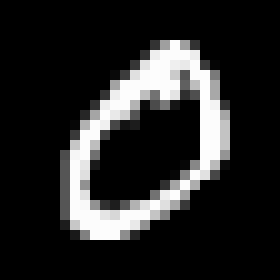

In [21]:
n = 1
image = train_in.reshape((60000, 28, 28, 1))[n:n+1, :, :, :]

f1 = np.repeat(image[0,:,:,0], 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

## Layer 1

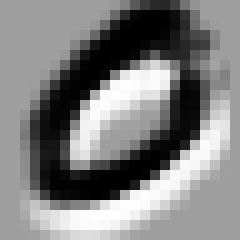

In [22]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 2]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

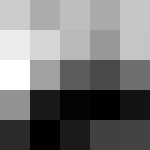

In [23]:
f1 = np.repeat(filters_1[:,:,0,2], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

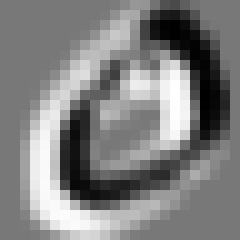

In [24]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 0]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

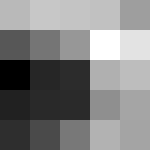

In [25]:
f1 = np.repeat(filters_1[:,:,0,0], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

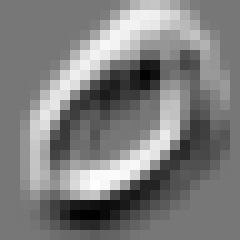

In [26]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: image})[0, :, :, 6]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

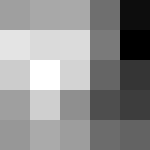

In [27]:
f1 = np.repeat(filters_1[:,:,0,4], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

# Transfer Learning to KNN

# Raw

In [25]:
knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(train_in[:5000], train_labels[:5000])

In [26]:
np.sum(
    np.argmax(knn.predict(train_in[:5000]), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / train_in[:5000].shape[0]

0.0464

In [27]:
np.sum(
    np.argmax(knn.predict(test_in[:5000]), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / test_labels[:5000].shape[0]

0.1064

## 1-Layers

In [28]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 4608))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 4608))

knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(mapped_train, train_labels[:5000])

In [30]:
np.sum(
    np.argmax(knn.predict(mapped_train), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_train.shape[0]

0.0358

In [31]:
np.sum(
    np.argmax(knn.predict(mapped_test), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.0858

## 3-Layers

In [32]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 72))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 72))

knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(mapped_train, train_labels[:5000])

In [34]:
np.sum(
    np.argmax(knn.predict(mapped_train), axis=1) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_train.shape[0]

0.0324

In [35]:
np.sum(
    np.argmax(knn.predict(mapped_test), axis=1) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.0702

# Transfer Learning to SVM

## Raw

In [36]:
svm = LinearSVC()
svm = svm.fit(train_in[:5000], np.argmax(train_labels[:5000], axis=1))

/home/fkwang/anaconda3/envs/experiments_archive/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [37]:
np.sum(
    svm.predict(train_in[:5000]) != \
    np.argmax(train_labels[:5000], axis=1)
) / train_in[:5000].shape[0]

0.0064

In [38]:
np.sum(
    svm.predict(test_in[:5000]) != \
    np.argmax(test_labels[:5000], axis=1)
) / test_labels[:5000].shape[0]

0.1712

## 1-Layers

In [39]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 4608))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 1), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 4608))

svm = LinearSVC()
svm = svm.fit(mapped_train, np.argmax(train_labels[:5000], axis=1))

/home/fkwang/anaconda3/envs/experiments_archive/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [41]:
np.sum(
    svm.predict(mapped_train) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_train.shape[0]

0.0

In [42]:
np.sum(
    svm.predict(mapped_test) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.0732

## 3-Layers

In [43]:
raw_train = train_in[:5000].reshape((5000, 28, 28, 1))
raw_test = test_in[:5000].reshape((5000, 28, 28, 1))

mapped_train = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_train})
mapped_train = mapped_train.reshape((5000, 72))
mapped_test = cnn.session.run(feed_forwards(cnn, cnn.input, 3), {cnn.input: raw_test})
mapped_test = mapped_test.reshape((5000, 72))

svm = LinearSVC()
svm = svm.fit(mapped_train, np.argmax(train_labels[:5000], axis=1))

/home/fkwang/anaconda3/envs/experiments_archive/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [44]:
np.sum(
    svm.predict(mapped_train) != \
    np.argmax(train_labels[:5000], axis=1)
) / mapped_train.shape[0]

0.0218

In [45]:
np.sum(
    svm.predict(mapped_test) != \
    np.argmax(test_labels[:5000], axis=1)
) / mapped_test.shape[0]

0.0644